In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'/home/ubuntu/varios/skforecast'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# set theme for matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDiff import ForecasterAutoregDiff
from sklearn.linear_model import LinearRegression   
from sklearn.ensemble import RandomForestRegressor
from lineartree import LinearForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.preprocessing import TimeSeriesDifferentiator

Train dates : 1991-07-01 00:00:00 --- 2003-03-01 00:00:00  (n=141)
Test dates  : 2003-04-01 00:00:00 --- 2008-06-01 00:00:00  (n=63)


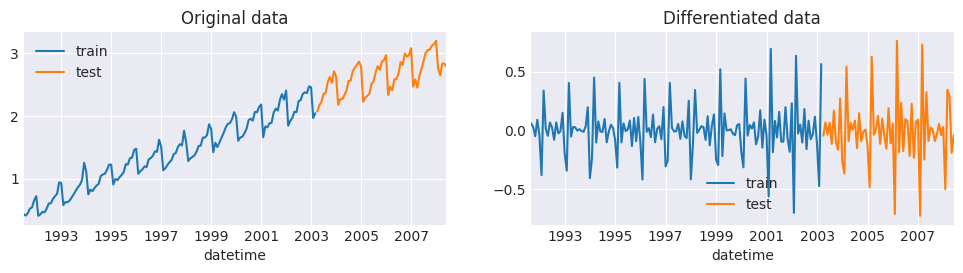

In [3]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Add a smooth positive trend
# ==============================================================================
t = np.arange(len(data))
data = data + 0.01 * t

# Data differentiated
# ==============================================================================
data_diff_1 = data.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

# Data partition train-test
# ==============================================================================
end_train = '2003-03-01 23:59:00'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, axs = plt.subplots(1, 2, figsize=(12, 2.5))
axs = axs.ravel()
data.loc[:end_train].plot(ax=axs[0], label='train')
data.loc[end_train:].plot(ax=axs[0], label='test')
axs[0].legend()
axs[0].set_title('Original data')

data_diff_2.loc[:end_train].plot(ax=axs[1], label='train')
data_diff_2.loc[end_train:].plot(ax=axs[1], label='test')
axs[1].legend()
axs[1].set_title('Differentiated data');

Series differentiated before training
-------------------------------------
Last window of training series: datetime
2002-01-01    0.230831
2002-02-01   -0.703838
2002-03-01    0.635863
2002-04-01   -0.026883
2002-05-01    0.049379
2002-06-01   -0.103919
2002-07-01    0.181810
2002-08-01   -0.159664
2002-09-01    0.082526
2002-10-01   -0.075052
2002-11-01   -0.033959
2002-12-01    0.116160
2003-01-01   -0.120611
2003-02-01   -0.475218
2003-03-01    0.564886
Freq: MS, Name: y, dtype: float64
Train matrix


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-12-01,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131,0.060142
1993-01-01,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131
1993-02-01,-0.195789,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558


Predictions


2003-04-01    2.023623
2003-05-01    2.090223
2003-06-01    2.098515
2003-07-01    2.214790
2003-08-01    2.229740
                ...   
2008-02-01   -6.617055
2008-03-01   -6.990611
2008-04-01   -7.459981
2008-05-01   -7.861564
2008-06-01   -8.300286
Length: 63, dtype: float64


Series differentiated during training
-------------------------------------
Last window of training series: datetime
2001-11-01    2.349590
2001-12-01    2.262313
2002-01-01    2.405868
2002-02-01    1.845584
2002-03-01    1.921165
2002-04-01    1.969862
2002-05-01    2.067938
2002-06-01    2.062096
2002-07-01    2.238064
2002-08-01    2.254368
2002-09-01    2.353198
2002-10-01    2.376976
2002-11-01    2.366796
2002-12-01    2.472776
2003-01-01    2.458145
2003-02-01    1.968296
2003-03-01    2.043333
Freq: MS, Name: y, dtype: float64
Train matrix


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-12-01,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131,0.060142
1993-01-01,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131
1993-02-01,-0.195789,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558


Predictions


2003-04-01    2.023623
2003-05-01    2.090223
2003-06-01    2.098515
2003-07-01    2.214790
2003-08-01    2.229740
                ...   
2008-02-01   -6.617055
2008-03-01   -6.990611
2008-04-01   -7.459981
2008-05-01   -7.861564
2008-06-01   -8.300286
Freq: MS, Name: pred, Length: 63, dtype: float64

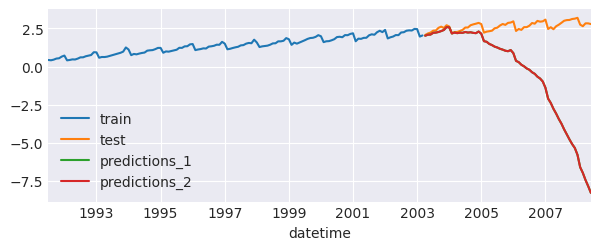

In [4]:
# Comparasion of results if the time series is differenciated before training or during the training
# =================================================================================================
steps = len(data.loc[end_train:])

print("Series differentiated before training")
print("-------------------------------------")
forecaster_1 = ForecasterAutoregDiff(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )

forecaster_1.fit(y=data_diff_2.loc[:end_train])
last_window_1 = forecaster_1.last_window
print(f"Last window of training series: {last_window_1}")
print("Train matrix")
X_train_1, y_train_1 = forecaster_1.create_train_X_y(data_diff_2.loc[:end_train])
display(X_train_1.head(3))
predictions_diff_2 = forecaster_1.predict(steps=steps)
predictions_diff_1 = pd.concat([data_diff_1.loc[:end_train].iloc[[-1]], predictions_diff_2]).cumsum()[1:]
predictions_1 = pd.concat([data.loc[:end_train].iloc[[-1]], predictions_diff_1]).cumsum()[1:]
print("Predictions")
display(predictions_1)
print("")

print("Series differentiated during training")
print("-------------------------------------")
forecaster_2 = ForecasterAutoregDiff(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation = 2
             )

forecaster_2.fit(y=data.loc[:end_train])
last_window_2 = forecaster_2.last_window
print(f"Last window of training series: {last_window_2}")
print("Train matrix")
X_train_2, y_train_2 = forecaster_2.create_train_X_y(data.loc[:end_train])
display(X_train_2.head(3))
predictions_2 = forecaster_2.predict(steps=steps)
print("Predictions")
display(predictions_2)

fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_1.plot(ax=ax, label='predictions_1')
predictions_2.plot(ax=ax, label='predictions_2')
ax.legend();

In [5]:
pd.testing.assert_frame_equal(X_train_1, X_train_2, check_names=True)
pd.testing.assert_frame_equal(forecaster_1.get_feature_importances(), forecaster_2.get_feature_importances(), check_names=True)
pd.testing.assert_series_equal(predictions_1.asfreq('MS'), predictions_2, check_names=False)

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

Results do not match for order =2

</div>

/home/ubuntu/anaconda3/envs/skforecast_10_py11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


2003-04-01    2.117351
2003-05-01    2.186148
2003-06-01    2.220894
2003-07-01    2.359803
Freq: MS, Name: predicted_mean, dtype: float64

2003-04-01    2.118218
2003-05-01    2.191517
2003-06-01    2.222458
2003-07-01    2.367209
Freq: MS, Name: pred, dtype: float64

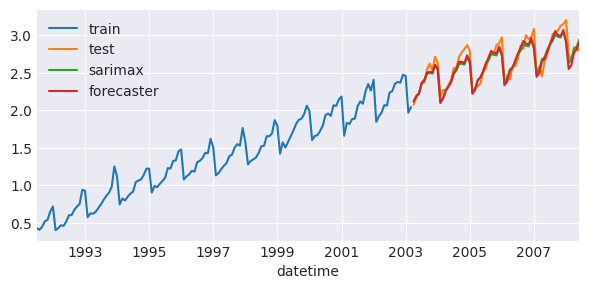

In [7]:
# Compare predictions with an arima (lags, 1, 0)
# ==============================================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX
steps = len(data.loc[end_train:])

sarimax = SARIMAX(data.loc[:end_train], order=(12, 2, 0))
res_sarimax = sarimax.fit(disp=False, maxiter=1000)
predictions_sarimax = res_sarimax.get_forecast(steps).predicted_mean
display(predictions_sarimax.head(4))

forecaster = ForecasterAutoregDiff(
                 regressor       = LinearRegression(),
                 lags            = 12,
                 differentiation = 2
            )
            
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=steps)
display(predictions.head(4))

fig, ax = plt.subplots(figsize=(7, 3))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_sarimax.plot(ax=ax, label='sarimax')
predictions.plot(ax=ax, label='forecaster')
ax.legend();